<a href="https://colab.research.google.com/github/RohittD/desai-eye-hospital-ai-application/blob/main/DRdetectionfinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATASET_DIR = "/content/drive/MyDrive/desia_eye[1]/DR/DR1"

print("Base exists:", os.path.exists(DATASET_DIR))
print("Subfolders:", os.listdir(DATASET_DIR))


Base exists: True
Subfolders: ['Diabetic_Retinopathy.ipynb', 'Vision Threatening', 'Non-vision Threatening', 'Normal']


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
DATASET_DIR = "/content/drive/MyDrive/desia_eye[1]/DR/DR1"

CLASSES = [
    "Normal",
    "Non-vision Threatening",
    "Vision Threatening"
]

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15


In [ ]:
print("Dataset exists:", os.path.exists(DATASET_DIR))
print("Classes found:", os.listdir(DATASET_DIR))


Dataset exists: True
Classes found: ['Diabetic_Retinopathy.ipynb', 'Vision Threatening', 'Non-vision Threatening', 'Normal']


In [ ]:
def rename_images(base_dir):
    for cls in os.listdir(base_dir):
        cls_path = os.path.join(base_dir, cls)
        if os.path.isdir(cls_path):
            for i, img in enumerate(os.listdir(cls_path)):
                old_path = os.path.join(cls_path, img)
                new_path = os.path.join(cls_path, f"{cls}_{i}.jpg")
                if not os.path.exists(new_path):
                    os.rename(old_path, new_path)

rename_images(DATASET_DIR)
print("✅ Images renamed successfully")


✅ Images renamed successfully


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


In [ ]:
import os

print("Folders inside DR1:")
print(os.listdir(DATASET_DIR))


Folders inside DR1:
['Diabetic_Retinopathy.ipynb', 'Vision Threatening', 'Non-vision Threatening', 'Normal']


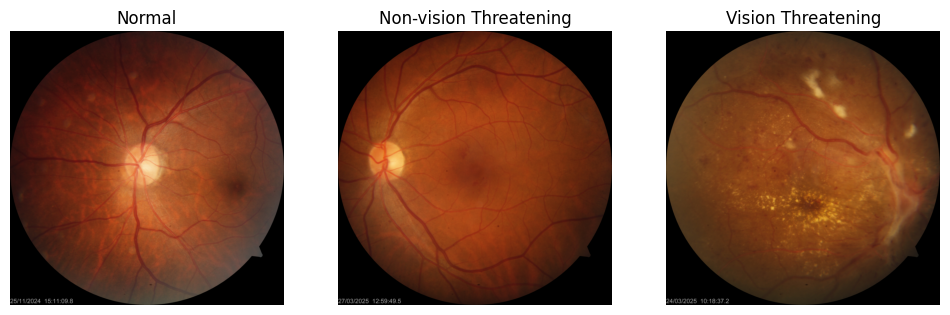

In [ ]:
import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plot_index = 1

for cls in CLASSES:
    cls_path = os.path.join(DATASET_DIR, cls)

    if not os.path.exists(cls_path):
        print(f"❌ Folder not found: {cls_path}")
        continue

    images = os.listdir(cls_path)
    if len(images) == 0:
        print(f"⚠️ No images in folder: {cls}")
        continue

    img_path = os.path.join(cls_path, images[0])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, len(CLASSES), plot_index)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

    plot_index += 1

plt.show()


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)


In [ ]:
train_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)


Found 72 images belonging to 3 classes.


In [ ]:
val_data = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 15 images belonging to 3 classes.


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [ ]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,243 (42.61 MB)

 Trainable params: 11,169,795 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 7s/step - accuracy: 0.4818 - loss: 2.0463 - val_accuracy: 0.3333 - val_loss: 1.1282
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 15s 7s/step - accuracy: 0.6535 - loss: 2.9961 - val_accuracy: 0.4667 - val_loss: 1.0429
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 5s/step - accuracy: 0.6515 - loss: 1.7993 - val_accuracy: 0.4667 - val_loss: 1.0495
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step - accuracy: 0.5035 - loss: 2.7498 - val_accuracy: 0.4000 - val_loss: 1.0516
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.6965 - loss: 1.4597 - val_accuracy: 0.4000 - val_loss: 1.0581
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.6240 - loss: 1.1699 - val_accuracy: 0.3333 - val_loss: 1.0717
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 6s/step - accuracy: 0.8056 - loss: 1.1155 - val_accuracy: 0.4000 - val_loss: 1.0892
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.7292 - loss: 1.3230 - val_accuracy: 0.3333 - val_loss: 1.1234
Epoch 9/

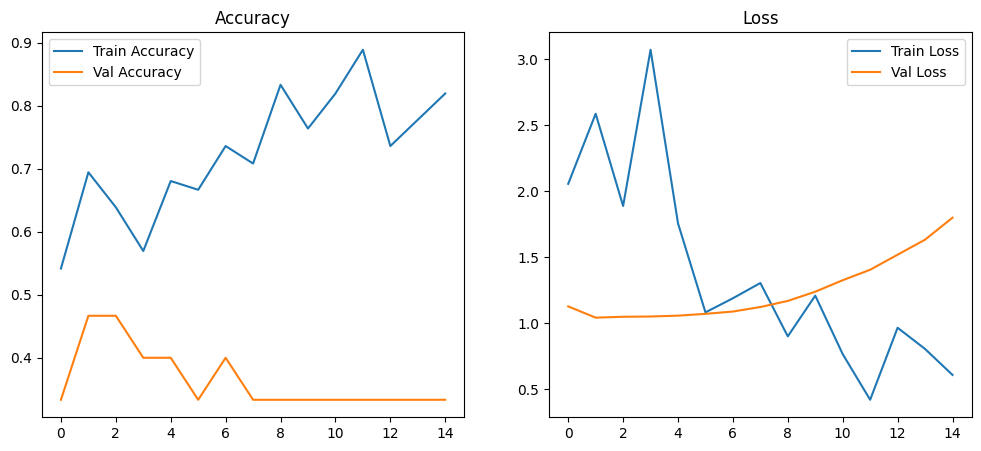

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

val_preds = model.predict(val_data)
y_pred = np.argmax(val_preds, axis=1)
y_true = val_data.classes


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


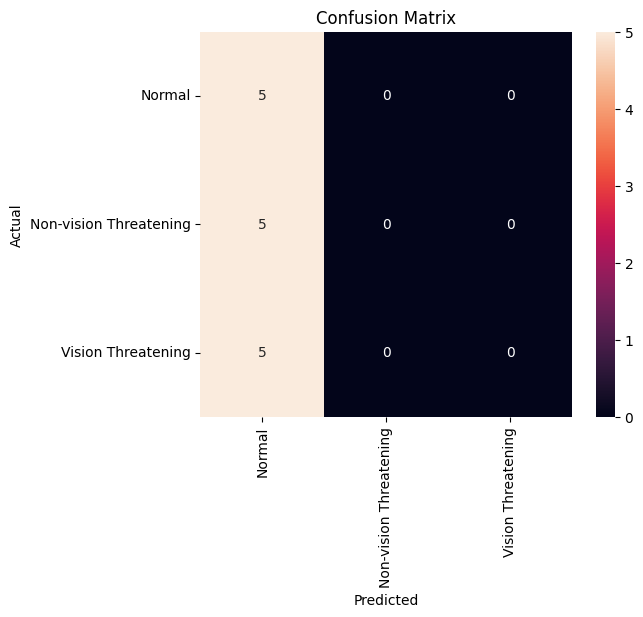

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=CLASSES,
            yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=CLASSES))


                        precision    recall  f1-score   support

                Normal       0.33      1.00      0.50         5
Non-vision Threatening       0.00      0.00      0.00         5
    Vision Threatening       0.00      0.00      0.00         5

              accuracy                           0.33        15
             macro avg       0.11      0.33      0.17        15
          weighted avg       0.11      0.33      0.17        15



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
def predict_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)[0]
    label = CLASSES[np.argmax(pred)]
    confidence = float(np.max(pred))

    plt.imshow(img[0])
    plt.title(f"{label} ({confidence*100:.2f}%)")
    plt.axis("off")
    plt.show()


In [ ]:
def final_confidence_only(image_path):
    import os
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt

    if not os.path.exists(image_path):
        print("❌ Image path does not exist")
        return

    img = cv2.imread(image_path)
    if img is None:
        print("❌ Unable to read image")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_input = np.expand_dims(img_normalized, axis=0)

    prediction = model.predict(img_input)[0]
    confidence = float(np.max(prediction)) * 100

    plt.figure(figsize=(5,5))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(f"Confidence: {confidence:.2f}%")
    plt.show()


In [ ]:
model.save("/content/drive/MyDrive/diabetic_retinopathy_model.h5")
print("✅ Model saved successfully")


✅ Model saved successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


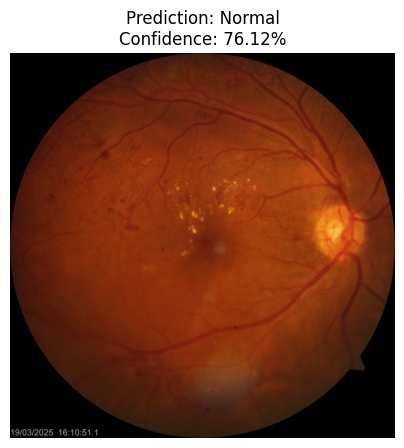

🔍 Class-wise Prediction Probabilities:
Normal: 76.12%
Non-vision Threatening: 1.76%
Vision Threatening: 22.11%


In [ ]:
test_image_path = "/content/drive/MyDrive/desia_eye[1]/DR/DR1/Vision Threatening/Vision Threatening_1.jpg"
final_evaluation(test_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Normal: 75.36%
Non-vision Threatening: 1.68%
Vision Threatening: 22.96%


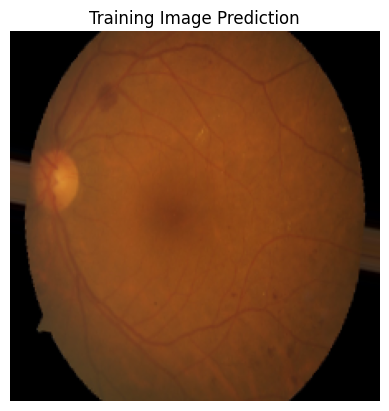

In [ ]:
# Pick one image directly from training data
cls_index = 2  # Vision threatening index
image_index = np.where(train_data.classes == cls_index)[0][0]

x, y = train_data[image_index // BATCH_SIZE]
img = x[image_index % BATCH_SIZE]

pred = model.predict(np.expand_dims(img, axis=0))[0]

for cls, prob in zip(CLASSES, pred):
    print(f"{cls}: {prob*100:.2f}%")

plt.imshow(img)
plt.title("Training Image Prediction")
plt.axis("off")
plt.show()
